In [928]:
# Dubbi:
#1 come mai le chiavi di a sembrano random?
#2 come faccio a non fare re-inserimento ?? Ricorda io estraggo d-1 cosi, più uno, più un altro che è quello di arrivo

In [966]:
import OffsetArrays
using Plots
using Revise
using StatsBase
using ProgressMeter
using SparseArrays, LinearAlgebra, IndexedGraphs, Graphs
srcpath = "../src"
include("$srcpath/functions.jl")

avgAUC (generic function with 1 method)

In [1040]:
# S=0   I=1
# The times go from ti = 0 to ti=T+1
# when ti=0 it means that i is the zero patient
# when ti=T+1 it means that i is never infected

λp = 0.3 # planted infection rate
λi = 0.3 #inferred infection rate

d = 3 # degree (fixed for now) 
T = 4 # discrete time

γp = 0.2 # planted autoinfection probability
γi = 0.2 # inferred autoinfection probability

N = 1000; #population size

# Population dynamics for the messages

In [1041]:
# Creation of the population
# we create μ as the set of all the N functions
# μ[k,ti,ck,τi,σk] is the value taken by the
# function μk with arguments ti,ck,τi,σk
# Using OffsetArrays we managed to keep notation 
# coherent with the notes: 

# i=1,...,N, 
# ti=0,...,T+1 
# c = 0,1
# σ=0,1,2

# The same is done for the ν function later
inizialization = ones(N,T+2,2,T+2,3) / (6*(T+2)^2)
μ = OffsetArrays.OffsetArray(inizialization,0,-1,-1,-1,-1);

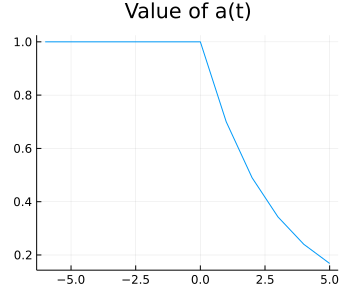

In [1042]:
#Precalculation of the function a := (1-λ)^{tθ(t)}, 
#useful for later (the function a appears
#  in the inferred time factor node)

#pcache = [(1-λi)^t for t = 1:T+1]
#a(t) = t <= 0 ? 1.0 : pcache[t]
a = Dict(zip(-T-2:T+1,[ t<=0 ? 1 : (1-λi)^t for t = -T-2:T+1]));
μold = copy(μ);
plot(LinRange(-T-2,T+1,2T+4),[a[t] for t=-T-2:T+1],size=(350,300),legend=false,title="Value of a(t)")

In [1043]:
a = fill(1.0,-2T:T+3)
a[0:T+1] .= [(1-λi)^t for t = 0:T+1]

6-element view(OffsetArray(::Vector{Float64}, -8:7), 0:5) with eltype Float64:
 1.0
 0.7
 0.48999999999999994
 0.3429999999999999
 0.24009999999999992
 0.16806999999999994

In [1044]:
ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1);
neighbours = rand(1:N,d-1);

In [1045]:
sample(0:10,4,replace=false)

4-element Vector{Int64}:
 9
 0
 7
 4

In [1111]:
tot_iterations = 40
@showprogress for iterations = 1:tot_iterations
    for l = 1:N
        # Extraction of disorder: state of individual i: xi0, delays: sij and sji

        xi0,sij,sji = rand_disorder(γp,λp)

        # Initialization of ν=0
        ν = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

        #Extraction of d-1 μ's from population
        neighbours = rand(1:N,d-1)

        #Beginning of calculations: we start by calculating the ν: 
        calculate_ν!(ν,μ,neighbours,xi0,T,γi,a)

        # Now we use the ν vector just calculated to extract the new μ.
        # We overwrite the μ in postition μ[l,:,:,:,:]

        # First we calculate and store the cumulated of ν with respect to 
        # planted time, i.e. the third argument. We call Σ this cumulated 
        Σ = cumsum(ν,dims=3)
        update_μ!(μ,ν,Σ,l,sij,sji,T,a)     
    end
end

#p1=plot(reshape(sum(μ,dims=1) ./ N,864))
#p1=plot!(reshape(sum(μold,dims=1) ./ N,864))
#μold = copy(μ);
#plot(p1)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


We plot the heatmaps of the messages

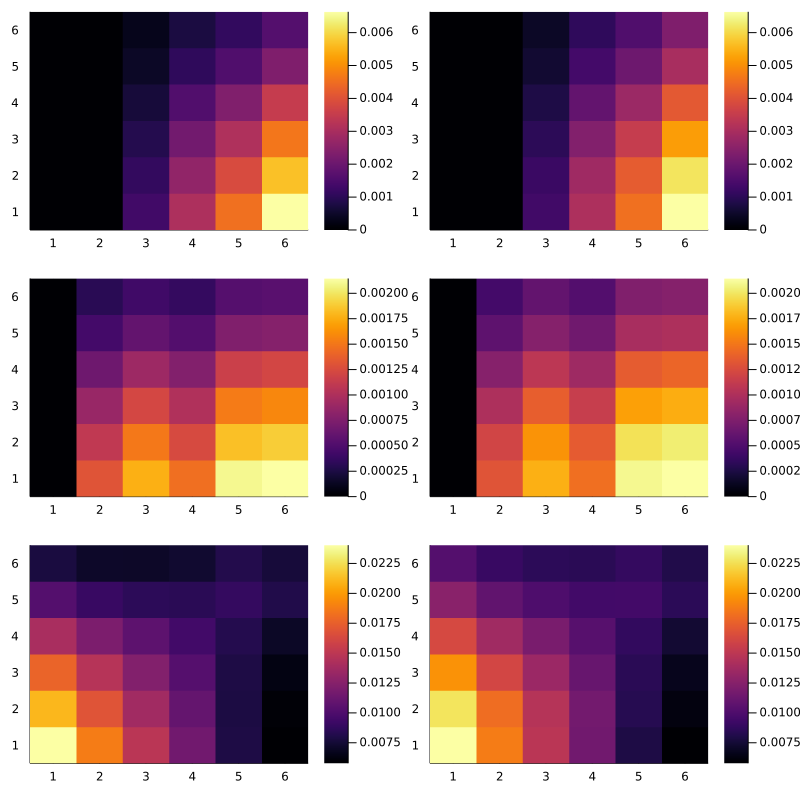

In [1112]:
pl1 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,0] ./ N,T+2,T+2))
pl2 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,0] ./ N,T+2,T+2))
pl3 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,1] ./ N,T+2,T+2))
pl4 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,1] ./ N,T+2,T+2))
pl5 = heatmap(reshape(sum(μ,dims=1)[:,:,0,:,2] ./ N,T+2,T+2))
pl6 = heatmap(reshape(sum(μ,dims=1)[:,:,1,:,2] ./ N,T+2,T+2))

plot(pl1,pl2,pl3,pl4,pl5,pl6,layout = (3,2),size = (800,800))

# From messages to marginals

In [1113]:
max_count = N;
p = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2),-1,-1,-1);
marg = OffsetArrays.OffsetArray(zeros(max_count,T+2,T+2),0,-1,-1);

In [1114]:
# Now we take out converged population of μ and use it to extract marginals.
# First we extract two ν's and then we combine it in order to obtain a marginal.
# In order to extract a ν we have to extract d-1 μ's. Therefore we extract two groups of 
# d-1 μ's and from them we calculate the two ν's. We also have to extract disorder.
@showprogress for l = 1:max_count
    group1 = rand(1:N,d-1) #groups of neighbours 
    group2 = rand(1:N,d-1)
    
    xi0,sij,sji = rand_disorder(γp,λp) #planted disorder
    xj0 = Int(rand() < γp);
    
    ν1 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)
    ν2 = OffsetArrays.OffsetArray(zeros(T+2,T+2,T+2,3),-1,-1,-1,-1)

    calculate_ν!(ν1,μ,group1,xi0,T,γi,a)
    calculate_ν!(ν2,μ,group2,xj0,T,γi,a)

    #Once the ν are calculated we have to cumulate with respect the third argument
    Σ = cumsum(ν2,dims=3)
    update_marginal!(marg,l,ν1,ν2,Σ,sij,sji,T)
end
marg2D = reshape((sum(marg,dims=1)./ max_count),T+2,T+2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


In [1115]:
include("$srcpath/functions.jl")

avgAUC (generic function with 1 method)

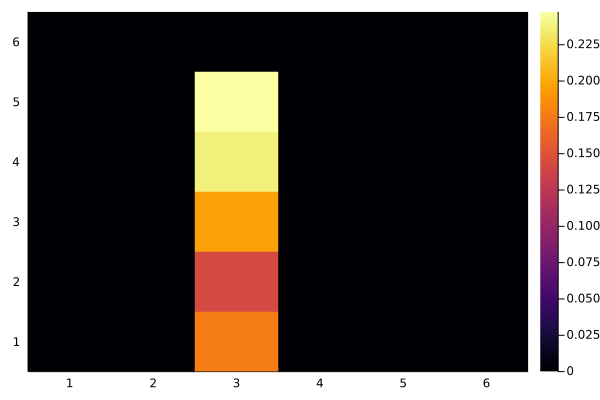

In [1116]:
heatmap(reshape((marg[16,:,:]),T+2,T+2))

In [1117]:
avgAUC(marg)

5-element Vector{Float64}:
 0.7257457822799895
 0.7875263807764049
 0.8440499703331626
 0.9113873044583934
 1.0

In [1118]:
for h = 1:10
    h<100 && continue
    @show h
end

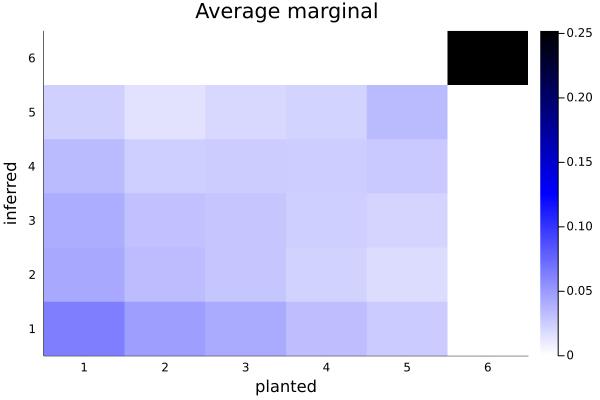

In [1119]:
pheat = heatmap((marg2D),c=[:white,:blue,:black],xlabel="planted",ylabel="inferred",title="Average marginal")

In [1120]:
sum([marg2D[t,t] for t=1:T+2])

0.4351697051345792

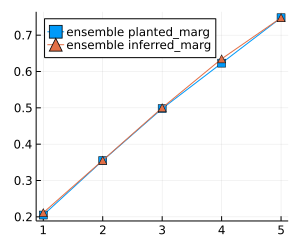

In [1121]:
p0 = plot(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),marker=:square,label="ensemble planted_marg")
p0 = plot!(cumsum(sum(marg2D,dims=2)[1:end-1],dims=1),marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
plot(p0,size=(300,250),legend=:topleft)

# Single Instance Inferernce with Sib

## No disorder
In this regime we don't have disorder, in the sense that the planted distribution is a delta. The planted observation is "all infected"

## General framework with disorder
Here the results of observations change because the parameter regime is non trivial. Therefore we need to sample a planted configuration, observe this configuration at final time and infere the single instance. We do this many times and we average so to compare with the ensemble results

### Check of the planted distribution
Here we check with a sampler and with sibyl that the planted ensemble marginal is correct.

In [876]:
include("$srcpath/sampler.jl")
include("$srcpath/BP.jl")

Ngraph = 1000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory

# First we initialize a single instance marginal y
# which will be the average over graph and particles
# and epidemic trajectory of the marginals
y = zeros(T+1)
yBP = zero(y)
# we average over totst iterations
totst = 5
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # we calculate the cumulative marginal (non-normalized)
    # and we sum it to the average marginal
    y .+= sum(x,dims=1)'
    p_sib = sibyl(Ngraph, T+1, G, [], γi, λi; maxit = 40, tol = 1e-2);
    avgmarg = sum(p_sib,dims=1)' ./ Ngraph
    yBP .+= avgmarg
end
#we normalize the average marginal
y ./= (Ngraph * totst)
yBP ./=  totst

LoadError: InterruptException:

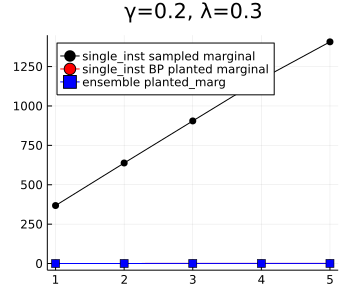

In [831]:
p0 = plot(y,c=:black,marker=:circle,label="single_inst sampled marginal",title="γ=$γp, λ=$λp")
p0 = plot!(yBP,c=:red,marker=:circle,label="single_inst BP planted marginal")
p0 = plot!(cumsum(sum(marg2D,dims=1)'[1:end-1],dims=1),c=:blue,marker=:square,size=(350,300),label="ensemble planted_marg",legend=:topleft)

### Comparison between inference (sibyl) and ensemble results
Here we check instead the results for the inferred marginal

In [832]:
yBP = zeros(T+1)
yBPerr = zero(yBP)
@showprogress for st = 1:totst
    # for every iteration we initialize a new graph
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    # we sample an epidemic
    sample!(x, G, λp, γp)
    # observations set in the form of 
    # [(individual,state,observation time, false_rate of the test)]
    # where state ∈ {0,1} respectively for S and I
    # The reason why there is a T+1 is that sibyl starts from time 1 to time T. 
    # Instead the ensemble goes from time 0 to time T  
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    #we now run the BP algorithm for the single instance defined above
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    yBP .+= sum(p_sib,dims=1)'
    yBPerr .+= sum(p_sib ,dims=1)' .^ 2
end

yBP ./= (Ngraph * totst)
#yBPerr ./= (Ngraph^2 * totst)
#yBPerr .= sqrt.(yBPerr .- yBP .^ 2) / sqrt(totst)



sib.iterate(damp=0.0): 7/40 3.552e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.122e-03/0.01      


LoadError: InterruptException:

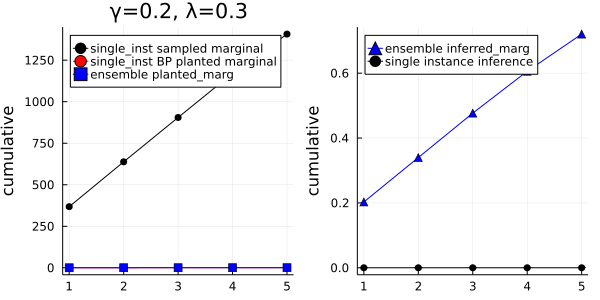

In [833]:
p1 = plot(cumsum(sum(marg2D,dims=2),dims=1)[1:end-1],c=:blue,marker=:utriangle,label="ensemble inferred_marg",legend=:bottomright)
p1 = plot!(yBP,yerr=yBPerr,c=:black,marker=:circle,label="single instance inference")
plot(p0,p1,size=(600,300),ylabel="cumulative",legend=:topleft)
#savefig("sibVSepid")

## 2D marginal comparison

In [834]:
function pdf(cdf_sib)
    N, T = size(cdf_sib) 
    p = zeros(N,T+1)
    p[:,1] .= cdf_sib[:,1]
    for t = 1:T-1
        p[:,t+1] .= cdf_sib[:,t+1] .- cdf_sib[:,t]
    end
    p[:,T+1] .= 1 .- cdf_sib[:,T]
    return p
end

pdf (generic function with 1 method)

In [878]:
include("../src/utils.jl")
totst = 5
AUC = zeros(T+1)
AUCerr = zeros(T+1)
AUCens = zeros(T+1)
sibylmarg2D = zeros(T+2,T+2)
@showprogress for st = 1:totst
    G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
    sample!(x, G, λp, γp)
    O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
    p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
    sib_pdf = pdf(p_sib)
    for t = 1:T+1
        AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
        AUCerr[t] += AUROC(ROC(x[:,t], p_sib[:,t]))^2
    end
    tau = T .- sum(x,dims=2) .+ 2; #set of planted times
    for τ = 1:T+2
        # We take the pdf only for individuals infected at time τ 
        sibylmarg2D[:,τ] .+= sum(sib_pdf .* (tau .== τ ),dims=1)' 
    end
    sing_inst_marg = zeros(Ngraph, T+2, T+2)
    for l = 1:Ngraph
        sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
    end
    sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);
    #AUCens = avgAUC(sing_inst_marg)
end
AUC ./= totst 
AUCerr .= sqrt.((AUCerr./ totst  .- (AUC .^ 2))./ totst ) 
sibylmarg2D ./= (Ngraph*totst);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47



sib.iterate(damp=0.0): 6/40 4.475e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.381e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.120e-03/0.01      
sib.iterate(damp=0.0): 6/40 7.120e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.837e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.397e-03/0.01      
sib.iterate(damp=0.0): 6/40 5.601e-03/0.01      
sib.iterate(damp=0.5): 0/40 2.073e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.030e-03/0.01      
sib.iterate(damp=0.0): 6/40 7.261e-03/0.01      
sib.iterate(damp=0.5): 0/40 3.404e-03/0.01      
sib.iterate(damp=0.9): 0/40 1.700e-03/0.01      
sib.iterate(damp=0.0): 7/40 3.226e-03/0.01      
sib.iterate(damp=0.5): 0/40 1.313e-03/0.01      


In [879]:
rand(0:1)

0

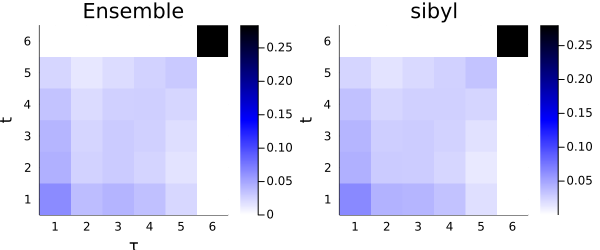

In [880]:
plot_sib = heatmap(sibylmarg2D,c=[:white,:blue,:black],csclxlabel="τ",ylabel="t",title="sibyl") 
plot_ens = heatmap(marg2D,c=[:white,:blue,:black],xlabel="τ",ylabel="t",title="Ensemble")
plot(plot_ens,plot_sib,size = (600,250))
#savefig("ensemble_VS_sibyl")

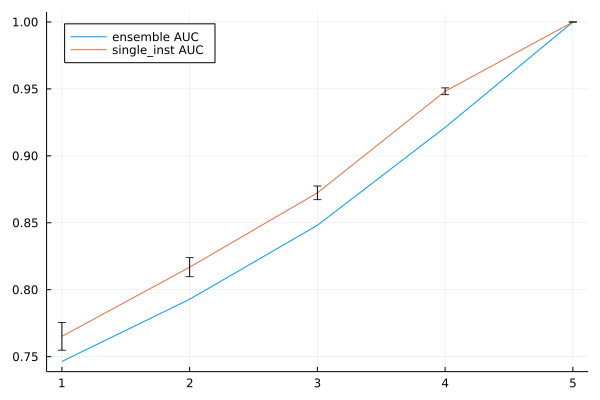

In [883]:
plot(avgAUC(marg),label="ensemble AUC")
plot!(AUC,label="single_inst AUC",legend=:topleft,yerr=AUCerr)
#plot!(AUCens,label="single_inst with ens AUC technique",legend=:topleft)
#savefig("AUC")

In [884]:
Ngraph = 5000 # size of the single instance graph
x = zeros(Int,Ngraph, T + 1) # a single epidemic trajectory
G = random_regular_graph(Ngraph,d) |> IndexedBiDiGraph 
sample!(x, G, λp, γp)
O = [(i,x[i,T+1],T+1,1e-10) for i = 1:Ngraph]
AUC = zeros(T+1)
p_sib = sibyl(Ngraph, T+1, G, O, γi, λi; maxit = 40, tol = 1e-2);
sib_pdf = pdf(p_sib)
for t = 1:T+1
    AUC[t] += AUROC(ROC(x[:,t], p_sib[:,t]))
end
tau = T .- sum(x,dims=2) .+ 2; #set of planted times
sing_inst_marg = zeros(Ngraph, T+2, T+2)
for l = 1:Ngraph
    sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
end
sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);



sib.iterate(damp=0.0): 6/40 5.848e-03/0.01      
sib.iterate(damp=0.5): 0/40 4.314e-03/0.01      


In [885]:
AUCens = avgAUC(sing_inst_marg)

5-element Vector{Float64}:
 0.7620443197199785
 0.8108396251085532
 0.8628050711821985
 0.9308274397657413
 1.0

In [886]:
AUC

5-element Vector{Float64}:
 0.7629568501862009
 0.8122522095959605
 0.8651909034996043
 0.9329367653367662
 1.0

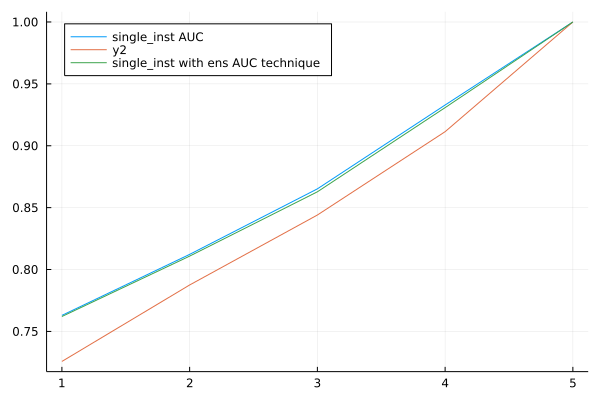

In [1122]:
include("$srcpath/functions.jl")
#plot(avgAUC(marg),label="ensemble AUC")
plot(AUC,label="single_inst AUC",legend=:topleft)
plot!(avgAUC(marg))
plot!(AUCens,label="single_inst with ens AUC technique",legend=:topleft)
#savefig("AUC.pdf")

In [849]:
savefig("AUC.pdf")

In [724]:
sing_inst_marg = zeros(Ngraph, T+2, T+2)
for l = 1:N
    sing_inst_marg[l,:,tau[l]] .= sib_pdf[l,:] 
end
sing_inst_marg = OffsetArrays.OffsetArray(sing_inst_marg,0,-1,-1);

In [725]:
sum(sib_pdf[15,:])

1.0

In [753]:
#heatmap(reshape((sing_inst_marg[22,:,:]),T+2,T+2))
avgAUC(marg)

5-element Vector{Float64}:
 0.7221236458722451
 0.7754674803959833
 0.8262976453753089
 0.9060895084372708
 1.0

In [713]:
avgAUC(marg)

5-element Vector{Float64}:
 0.7282562842750441
 0.7845032825914436
 0.8323994620901639
 0.9121054945054945
 1.0

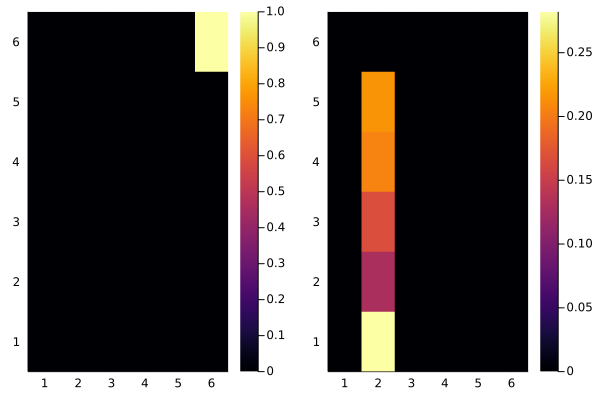

In [777]:
l = 3
h1 = heatmap(reshape((sing_inst_marg[l+1,:,:]),T+2,T+2))
h2 = heatmap(reshape((sing_inst_marg[l,:,:]),T+2,T+2))
plot(h1,h2)

In [715]:
[collect(1:6)' collect(8:12)']

1×11 adjoint(::Vector{Int64}) with eltype Int64:
 1  2  3  4  5  6  8  9  10  11  12

In [716]:
[[2 3] [4 5 6] ]

1×5 Matrix{Int64}:
 2  3  4  5  6

In [717]:
collect(1:6)

6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6